In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from scipy.io import savemat,loadmat
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings("ignore")

In [10]:
import numpy as np
import random
import copy
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


''' 种群初始化函数 '''
def initial(pop, dim, ub, lb):
    X = np.zeros([pop, dim])
    for i in range(pop):
        for j in range(dim):
            X[i, j] = random.random()*(ub[j] - lb[j]) + lb[j]
    
    return X,lb,ub
            
'''边界检查函数'''
def BorderCheck(X,ub,lb,pop,dim):
    for i in range(pop):
        for j in range(dim):
            if X[i,j]>ub[j]:
                X[i,j] = ub[j]
            elif X[i,j]<lb[j]:
                X[i,j] = lb[j]
    return X
    
    
'''计算适应度函数'''
def CaculateFitness(X,fun):
    pop = X.shape[0]
    fitness = np.zeros([pop, 1])
    for i in range(pop):
        fitness[i] ,Model = fun(X[i, :])
    return fitness

'''适应度排序'''
def SortFitness(Fit):
    fitness = np.sort(Fit, axis=0)
    index = np.argsort(Fit, axis=0)
    return fitness,index


'''根据适应度对位置进行排序'''
def SortPosition(X,index):
    Xnew = np.zeros(X.shape)
    for i in range(X.shape[0]):
        Xnew[i,:] = X[index[i],:]
    return Xnew


'''粒子群算法'''
def SAPSO(pop,dim,lb,ub,MaxIter,fun,Vmin,Vmax):
    # 参数设置
    w = 0.9      # 惯性因子
    c1 = 2       # 加速常数
    c2 = 2       # 加速常数
    X,lb,ub = initial(pop, dim, ub, lb) #初始化种群
    V,Vmin,Vmax = initial(pop, dim, Vmax, Vmin) #初始速度
    fitness = CaculateFitness(X,fun) #计算适应度值
    fitness,sortIndex = SortFitness(fitness) #对适应度值排序
    X = SortPosition(X,sortIndex) #种群排序
    GbestScore = copy.copy(fitness[0])
    GbestPositon = copy.copy(X[0,:])
    Curve = np.zeros([MaxIter,1])
    Pbest = copy.copy(X)
    fitnessPbest = copy.copy(fitness)
    for i in range(MaxIter):
        print("第" + str(i) + "次迭代")
        for j in range(pop):
           #速度更新
           V[j,:] = w*V[j,:] + c1*np.random.random()*(Pbest[j,:] - X[j,:]) + c2*np.random.random()*(GbestPositon - X[j,:])
           #速度边界检查
           for ii in range(dim):
               if V[j,ii]<Vmin[ii]:
                   V[j,ii]=Vmin[ii]           
               if V[j,ii]>Vmax[ii]:
                   V[j,ii] = Vmax[ii]
            #位置更新
           X[j,:] = X[j,:] + V[j,:]
            #位置边界检查
           for ii in range(dim):
               if X[j,ii]<lb[ii]:
                   V[j,ii]=lb[ii]           
               if X[j,ii]>ub[ii]:
                   V[j,ii] = ub[ii]
           fitness[j] ,Model = fun(X[j,:])
           if fitness[j]<fitnessPbest[j]:
               Pbest[j,:]=copy.copy(X[j,:])
               fitnessPbest[j] = copy.copy(fitness[j])
           if fitness[j]<GbestScore[0]:
               GbestScore[0] = copy.copy(fitness[j])
               GbestPositon = copy.copy(X[j,:])
               
        Curve[i] = GbestScore
    
    return GbestScore,GbestPositon,Curve

In [3]:
# 转换成监督数据，将每个特征转换成21列数据，20->1，20组预测一组
def series_to_supervised(data, n_in=20, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]  #计算特征的数量
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    # 将20组输入数据依次向下移动20,19,...3,2,1行，将数据加入cols列表（技巧：(n_in, 0, -1)中的-1指倒序循环，步长为1）
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    # 将一组输出数据加入cols列表（技巧：其中i=0）
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # cols列表(list)中现在有21块经过下移后的数据(即：df(-20),df(-19),...df(-2),df(-1),df)，将四块数据按列 并排合并
    agg = pd.concat(cols, axis=1)
    # 给合并后的数据添加列名
    agg.columns = names
    # print(agg)
    # 删除NaN值列
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [4]:
dataset = pd.read_excel("816480.xlsx")
fratures_Corrected_irradiance = [
    'Flow (Veh/5 Minutes)'
]
values = dataset[fratures_Corrected_irradiance].values
n_features=1 #特征数量

In [5]:
# 标准化
scaler =StandardScaler()
scaled = scaler.fit_transform(values)

In [6]:
n_in = 3
n_out = 1
# 构造一个20->1的监督学习型数据
reframed = series_to_supervised(scaled, n_in=n_in, n_out=n_out)
values=reframed.values

In [7]:
#训练集和测试集的划分比例
ratio=0.8 
N=int(len(values) *ratio)
train = values[:N, :]
test = values[N:, :]

# 划分输入和输出,split into input and outputs
n_obs = n_in *  n_features
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
train_y=train_y.reshape(-1,1)
test_y=test_y.reshape(-1,1)

(1149, 3) (1149,) (288, 3) (288,)


In [8]:
'''适应度函数定义'''
def fun(x):
    # 训练随机森林
    hidden_layer = int(x[0])  # 神经元个数
    # hidden_layer1 = int(x[1])  # 第二层神经元个数

    Model = MLPRegressor(hidden_layer_sizes=(hidden_layer,), max_iter=60, random_state=10, verbose=0)  # BP神经网络回归模型

    Model.fit(train_X, train_y)  # 训练

    # 测试集测试
    result1 = Model.predict(test_X)

    fitness = np.mean(np.square((result1 - test_y)))
    return fitness, Model

In [11]:
#设鱼参数
pop = 20  # 种群数量
MaxIter = 50  # 最大迭代次数
dim = 1  # 维度
lb = np.matrix([[10]])  # 下边界
ub = np.matrix([[100]])  # 上边界
fobj = fun
Vmin = -5*np.ones([dim, 1]) #速度下边界
Vmax = 5*np.ones([dim, 1])#速度上边界
GbestScore,GbestPositon,Curve = SAPSO(pop,dim,lb,ub,MaxIter,fobj,Vmin,Vmax)
print('最优适应度值：', GbestScore)
print('hidden_layer最优解：', int(GbestPositon[0]))

第0次迭代
第1次迭代
第2次迭代
第3次迭代
第4次迭代
第5次迭代
第6次迭代
第7次迭代
第8次迭代
第9次迭代
第10次迭代
第11次迭代
第12次迭代
第13次迭代
第14次迭代
第15次迭代
第16次迭代
第17次迭代
第18次迭代
第19次迭代
第20次迭代
第21次迭代
第22次迭代
第23次迭代
第24次迭代
第25次迭代
第26次迭代
第27次迭代
第28次迭代
第29次迭代
第30次迭代
第31次迭代
第32次迭代
第33次迭代
第34次迭代
第35次迭代
第36次迭代
第37次迭代
第38次迭代
第39次迭代
第40次迭代
第41次迭代
第42次迭代
第43次迭代
第44次迭代
第45次迭代
第46次迭代
第47次迭代
第48次迭代
第49次迭代
最优适应度值： [1.90857709]


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [15]:
# 利用最优参数训练
hidden_layer = int(GbestPositon[0])  # 随机森林个数
Model=MLPRegressor(hidden_layer_sizes=(hidden_layer,), max_iter=80, random_state=10, verbose=2)  # BP神经网络回归模型
Model.fit(train_X,train_y)

Iteration 1, loss = 0.61170121
Iteration 2, loss = 0.55333432
Iteration 3, loss = 0.50064073
Iteration 4, loss = 0.45450394
Iteration 5, loss = 0.41306080
Iteration 6, loss = 0.37508848
Iteration 7, loss = 0.34066695
Iteration 8, loss = 0.30848920
Iteration 9, loss = 0.27827416
Iteration 10, loss = 0.25018182
Iteration 11, loss = 0.22452228
Iteration 12, loss = 0.20048427
Iteration 13, loss = 0.17837378
Iteration 14, loss = 0.15799613
Iteration 15, loss = 0.13912271
Iteration 16, loss = 0.12232772
Iteration 17, loss = 0.10682994
Iteration 18, loss = 0.09309963
Iteration 19, loss = 0.08080717
Iteration 20, loss = 0.07035842
Iteration 21, loss = 0.06104494
Iteration 22, loss = 0.05319184
Iteration 23, loss = 0.04665769
Iteration 24, loss = 0.04122364
Iteration 25, loss = 0.03680848
Iteration 26, loss = 0.03339467
Iteration 27, loss = 0.03063888
Iteration 28, loss = 0.02855159
Iteration 29, loss = 0.02691515
Iteration 30, loss = 0.02571556
Iteration 31, loss = 0.02483653
Iteration 32, los

MLPRegressor(hidden_layer_sizes=(19,), max_iter=80, random_state=10, verbose=2)

In [16]:
# 作出预测
yhat = Model.predict(test_X)
yhat=yhat.reshape(-1,1)
yhat = np.repeat(yhat,n_in*n_features+n_out, axis=-1)
inv_yhat=scaler.inverse_transform(np.reshape(yhat,(len(yhat),n_in*n_features+n_out)))[:,0]
test_y=test_y.reshape(-1,1)
y = np.repeat(test_y,n_in*n_features+n_out, axis=-1)
inv_y=scaler.inverse_transform(np.reshape(y,(len(test_y),n_in*n_features+n_out)))[:,0]

In [17]:
# 计算RMSE
def mape(y_true, y_pred):
    #评价指标MAPE
    record=[]
    for index in range(len(y_true)):
        if abs(y_true[index])>10:
            temp_mape=np.abs((y_pred[index] - y_true[index]) / y_true[index])
            record.append(temp_mape)
    return np.mean(record) * 100
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.7f' % rmse)
print('Test MAE: %.7f' % mean_absolute_error(inv_y, inv_yhat))
print('Test MAPE: %.7f' % mape(inv_y, inv_yhat))
print('Test R2: %.7f' % r2_score(inv_y, inv_yhat))

Test RMSE: 37.0809859
Test MAE: 28.2116916
Test MAPE: 9.7117140
Test R2: 0.9483726


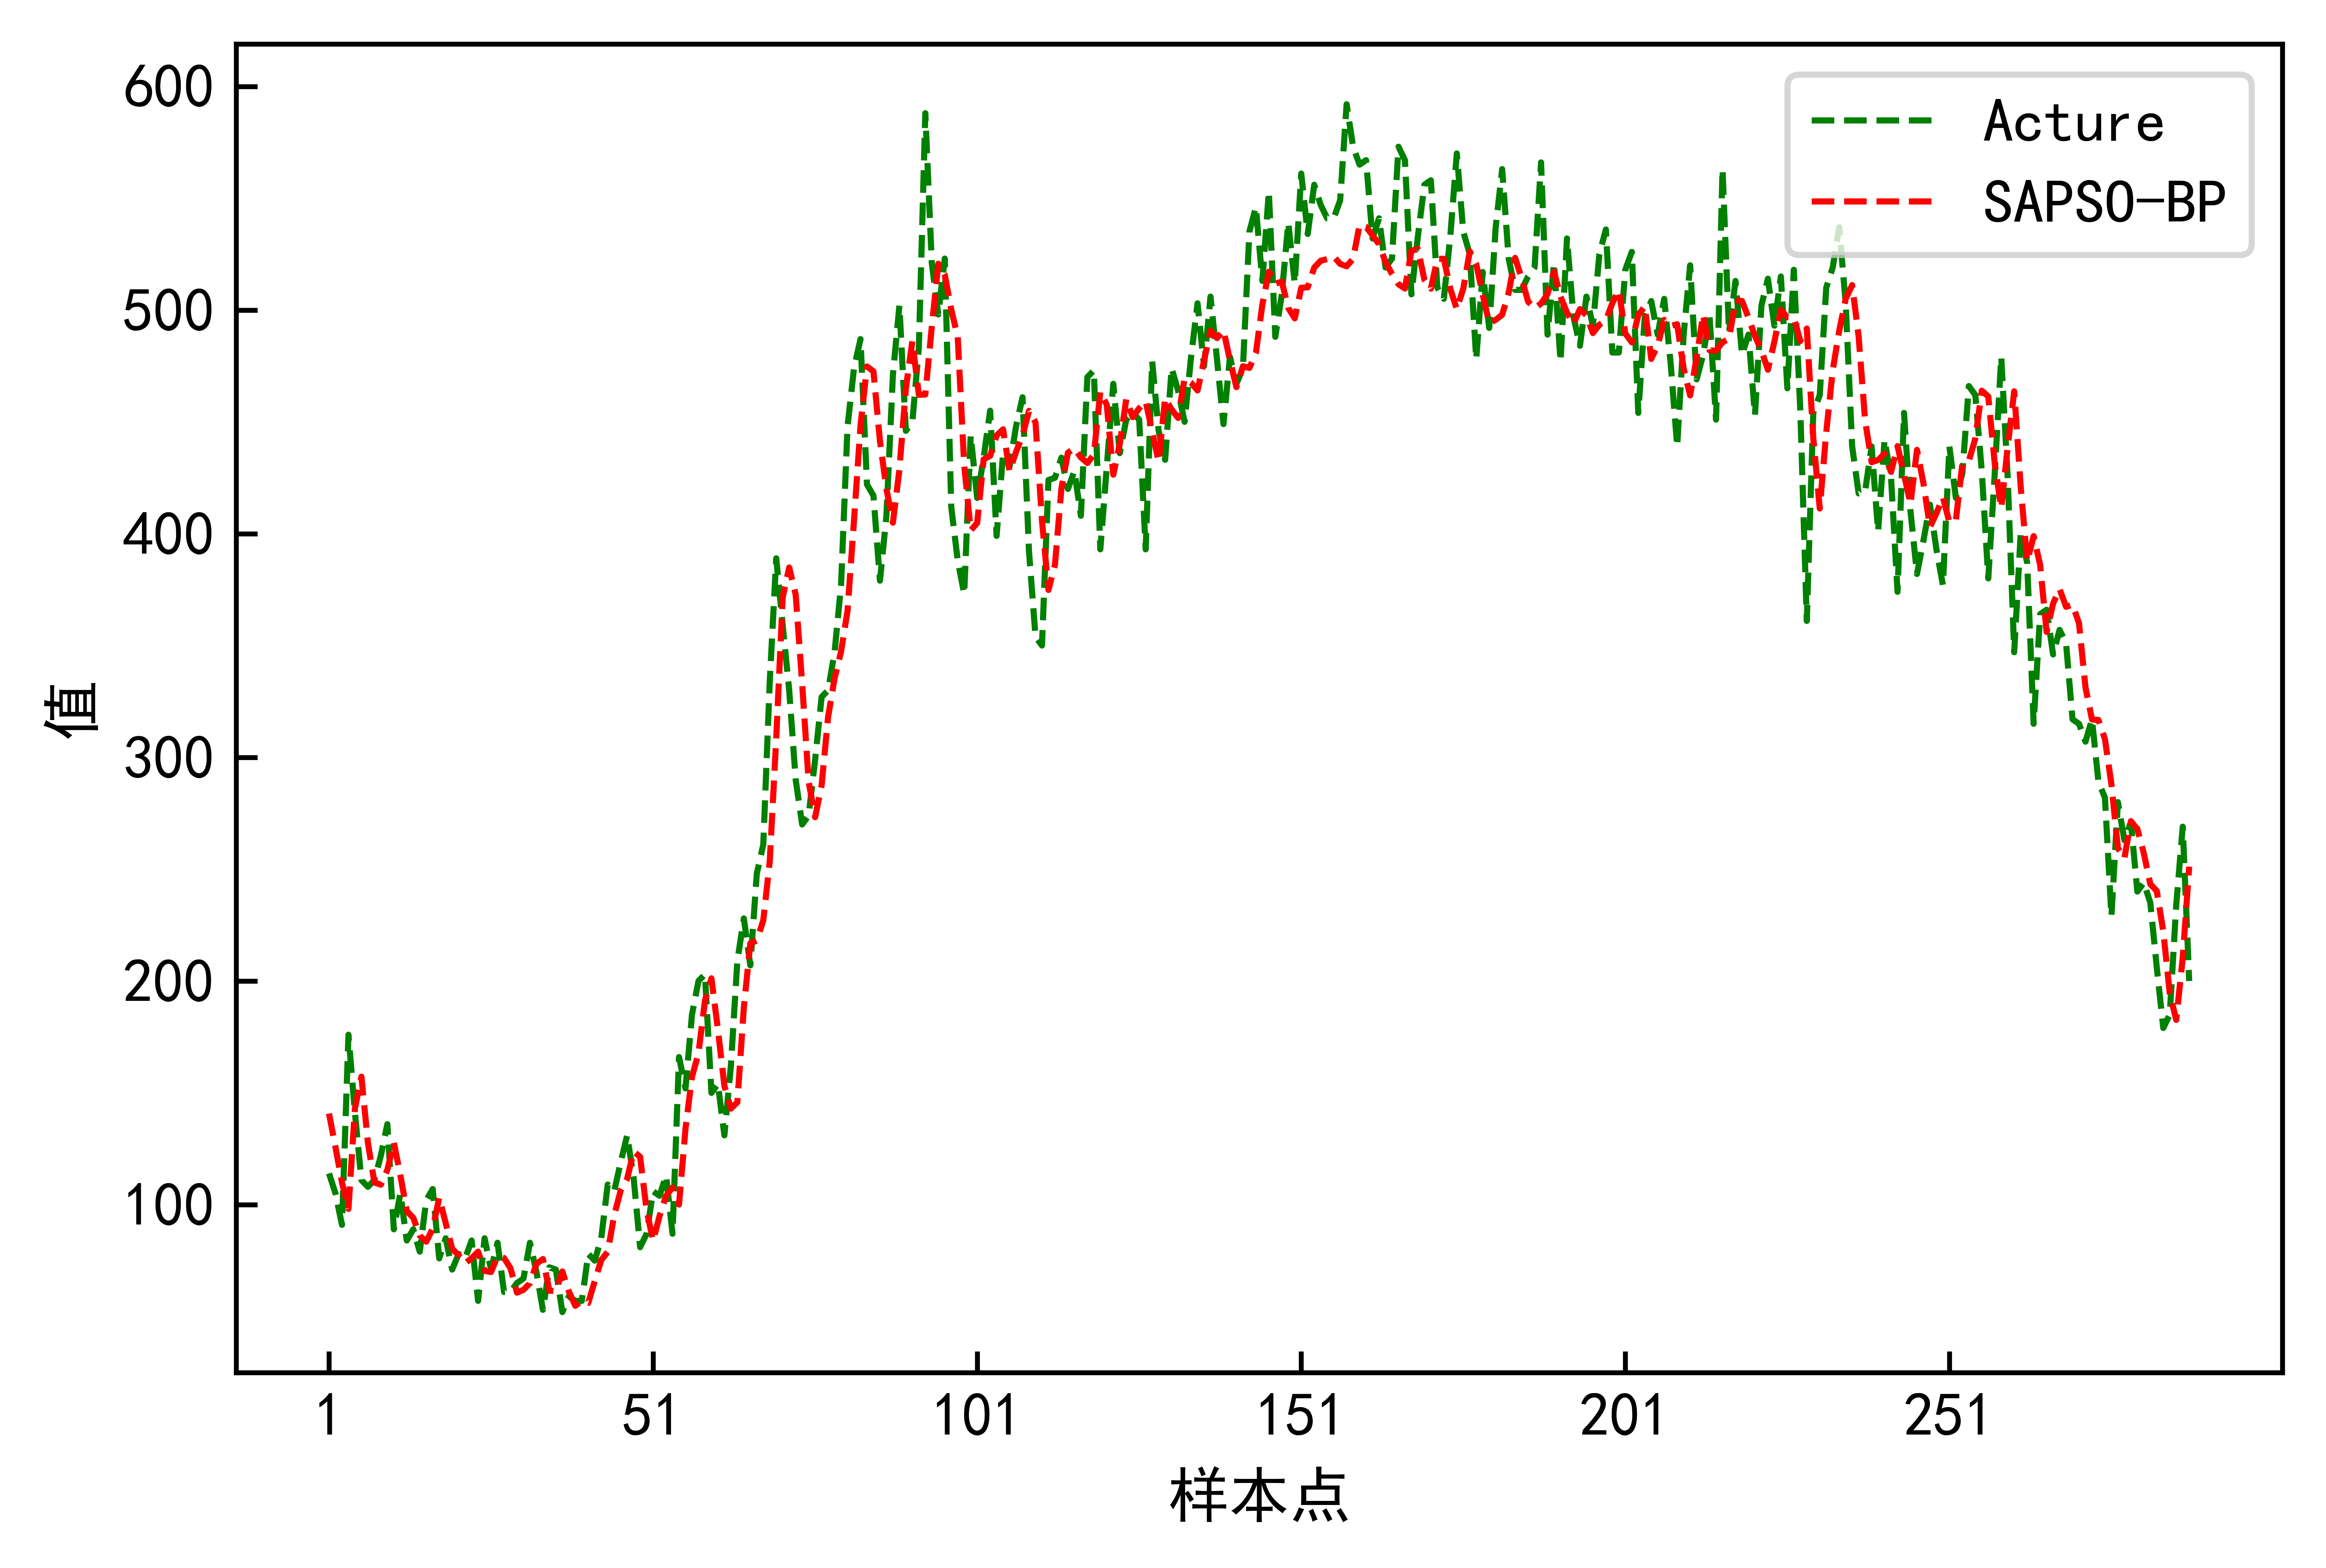

In [18]:
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
plt.rcParams['font.sans-serif']=['Simhei']  #解决画图中文不显示问题
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.figure(figsize=(6,4),dpi=600)
x=range(1, len(inv_yhat)+1)
plt.xticks(x[::50])
plt.tick_params(labelsize=10)  #改变刻度字体大小
plt.plot(x, inv_y, linestyle="--",color='g',linewidth=1, label='Acture')
plt.plot(x, inv_yhat, color='red',linestyle="--",linewidth=1,label='SAPSO-BP')
# plt.plot(x, inv_y,color='g',linewidth=1, label='真实值')
# plt.plot(x, inv_yhat,color='red',linestyle="--",linewidth=1,label='预测值')
plt.rcParams.update({'font.size': 10})  #改变图例里面的字体大小
plt.legend(loc='upper right')
plt.xlabel("样本点",fontsize=10)
plt.ylabel("值",fontsize=10)
# plt.xlim(xmin=600,xmax=700)  #显示600-1000的值   局部放大有利于观察
# plt.savefig('figure/LSTM预测结果图.png')
plt.show()

In [19]:
#保存预测结果
savemat('结果/sapso_bp_result.mat',{'true':inv_y,'pred':inv_yhat})